<a href="https://colab.research.google.com/github/Quiroo/Trabajo-Final-CV/blob/main/Trabajo_Final_CNN_Style_Transfer_Espona.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Style Transfer

<img src="https://i0.wp.com/chelseatroy.com/wp-content/uploads/2018/12/neural_style_transfer.png?resize=768%2C311&ssl=1">

La idea de este trabajo final es reproducir el siguiente paper:

https://arxiv.org/pdf/1508.06576.pdf

El objetivo es transferir el estilo de una imagen dada a otra imagen distinta. 

Como hemos visto en clase, las primeras capas de una red convolucional se activan ante la presencia de ciertos patrones vinculados a detalles muy pequeños.

A medida que avanzamos en las distintas capas de una red neuronal convolucional, los filtros se van activando a medida que detectan patrones de formas cada vez mas complejos.

Lo que propone este paper es asignarle a la activación de las primeras capas de una red neuronal convolucional (por ejemplo VGG19) la definición del estilo y a la activación de las últimas capas de la red neuronal convolucional, la definición del contenido.

La idea de este paper es, a partir de dos imágenes (una que aporte el estilo y otra que aporte el contenido) analizar cómo es la activación de las primeras capas para la imagen que aporta el estilo y cómo es la activación de las últimas capas de la red convolucional para la imagen que aporta el contenido. A partir de esto se intentará sintetizar una imagen que active los filtros de las primeras capas que se activaron con la imagen que aporta el estilo y los filtros de las últimas capas que se activaron con la imagen que aporta el contenido.

A este procedimiento se lo denomina neural style transfer.

# En este trabajo se deberá leer el paper mencionado y en base a ello, entender la implementación que se muestra a continuación y contestar preguntas sobre la misma.

# Una metodología posible es hacer una lectura rápida del paper (aunque esto signifique no entender algunos detalles del mismo) y luego ir analizando el código y respondiendo las preguntas. A medida que se planteen las preguntas, volviendo a leer secciones específicas del paper terminará de entender los detalles que pudieran haber quedado pendientes.

Lo primero que haremos es cargar dos imágenes, una que aporte el estilo y otra que aporte el contenido. A tal fin utilizaremos imágenes disponibles en la web.

In [ ]:
%tensorflow_version 1.x

TensorFlow 1.x selected.


In [ ]:
# Imagen para estilo
#!wget https://upload.wikimedia.org/wikipedia/commons/5/52/La_noche_estrellada1.jpg
#!wget https://conceptodefinicion.de/wp-content/uploads/2020/12/arte.jpg 
!wget https://raw.githubusercontent.com/Quiroo/Trabajo-Final-CV/main/arte_style.jpg

# Imagen para contenido
#!wget https://upload.wikimedia.org/wikipedia/commons/thumb/f/f4/Neckarfront_T%C3%BCbingen_Mai_2017.jpg/775px-Neckarfront_T%C3%BCbingen_Mai_2017.jpg
#!wget https://i.ibb.co/tsvJj48/kiro-LA.jpg
!wget https://raw.githubusercontent.com/Quiroo/Trabajo-Final-CV/main/kiro_test.jpg

# Creamos el directorio para los archivos de salida
!mkdir /content/output

--2021-09-30 18:47:43--  https://raw.githubusercontent.com/Quiroo/Trabajo-Final-CV/main/arte_style.jpg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 69725 (68K) [image/jpeg]
Saving to: ‘arte_style.jpg’

arte_style.jpg      100%[===================>]  68.09K  --.-KB/s    in 0.005s  

2021-09-30 18:47:43 (14.6 MB/s) - ‘arte_style.jpg’ saved [69725/69725]

--2021-09-30 18:47:43--  https://raw.githubusercontent.com/Quiroo/Trabajo-Final-CV/main/kiro_test.jpg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 177540 (173K) [image/jpeg]
S

In [ ]:
from keras.preprocessing.image import load_img, save_img, img_to_array
import numpy as np
from scipy.optimize import fmin_l_bfgs_b
import time
import argparse

from keras.applications import vgg19
from keras import backend as K
from pathlib import Path

Using TensorFlow backend.


In [ ]:
ls

arte_style.jpg  kiro_test.jpg  output/  sample_data/


In [ ]:
# Definimos las imagenes que vamos a utilizar, y el directorio de salida

#base_image_path = Path("./775px-Neckarfront_Tübingen_Mai_2017.jpg")
#style_reference_image_path = Path("./La_noche_estrellada1.jpg")

#base_image_path = Path("./kiro-LA.jpg")
#style_reference_image_path = Path("./arte.jpg")

base_image_path = Path("./kiro_test.jpg")
style_reference_image_path = Path("./arte_style.jpg")

result_prefix = Path("./output")
iterations = 100

# 1) En base a lo visto en el paper ¿Qué significan los parámetros definidos en la siguiente celda?

Respuesta:

Los parametros definidos en la siguiente celda hacen referencia a la relación de peso que se le da entre el contenido y el estilo.

Siendo α y β los factores de ponderación para la reconstrucción de contenido y estilo, respectivamente.
α = content_weight
β = style_weight

Se relaciona con la Loss de la siguiente manera:
Ltotal(p,a, x) = αLcontent(p, x) + βLstyle(a, x) 

Por último toal_variation_weight es un factor de suavizado de la loss


In [ ]:
total_variation_weight = 0.1
style_weight = 10
content_weight = 1

In [ ]:
ls

arte_style.jpg  kiro_test.jpg  output/  sample_data/


In [ ]:
# Neckarfront tiene dimension 775 x 599
# Estrallada tiene dimension 745 x 596

# Definimos el tamaño de las imágenes a utilizar
width, height = load_img(base_image_path).size
img_nrows = 400
img_ncols = int(width * img_nrows / height)

In [ ]:
print(width)
print(height)
print(img_nrows)
print(img_ncols)

965
723
400
533


# 2) Explicar qué hace la siguiente celda. En especial las últimas dos líneas de la función antes del return. ¿Por qué?

Ayuda: https://keras.io/applications/

Respuesta:

    img = load_img(image_path, target_size=(img_nrows, img_ncols))
Carga la imagen con las dimensiones establecidas 400 x 533 (x3 RGB).

    img = img_to_array(img)
Convierte la imágen en un numpay 3D array.

    img = np.expand_dims(img, axis=0)
Inserta un nuevo eje que aparecerá en la posición (0) del eje en la forma de matriz expandida. Esto se realiza para hacer coincidir el formato NHWC (número, altura, ancho, canal) de keras.

    img = vgg19.preprocess_input(img)
Convierte las imágenes de entrada de RGB a BGR, luego centrará en cero cada canal de color con respecto al conjunto de datos de ImageNet, sin escalar. Se definen los pesos de ImageNet al momento de crear el modelo.



In [ ]:
def preprocess_image(image_path):
    img = load_img(image_path, target_size=(img_nrows, img_ncols))
    img = img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = vgg19.preprocess_input(img)
    return img

# 3) Habiendo comprendido lo que hace la celda anterior, explique de manera muy concisa qué hace la siguiente celda. ¿Qué relación tiene con la celda anterior?

Respuesta:

Con el deprocesamiento de la imagen, se elimina el centro cero a cada capa y reordena nuevamente a RGB. Se utilizará para reconstruir la imagen de salida.

In [ ]:
def deprocess_image(x):
    x = x.reshape((img_nrows, img_ncols, 3))
    # Remove zero-center by mean pixel
    x[:, :, 0] += 103.939
    x[:, :, 1] += 116.779
    x[:, :, 2] += 123.68
    # 'BGR'->'RGB'
    x = x[:, :, ::-1]
    x = np.clip(x, 0, 255).astype('uint8')
    return x

In [ ]:
# get tensor representations of our images
# K.variable convierte un numpy array en un tensor, para 
base_image = K.variable(preprocess_image(base_image_path))
style_reference_image = K.variable(preprocess_image(style_reference_image_path))

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [ ]:
combination_image = K.placeholder((1, img_nrows, img_ncols, 3))

Aclaración:

La siguiente celda sirve para procesar las tres imagenes (contenido, estilo y salida) en un solo batch.

In [ ]:
# combine the 3 images into a single Keras tensor
input_tensor = K.concatenate([base_image,
                              style_reference_image,
                              combination_image], axis=0)

In [ ]:
# build the VGG19 network with our 3 images as input
# the model will be loaded with pre-trained ImageNet weights
model = vgg19.VGG19(input_tensor=input_tensor,
                    weights='imagenet', include_top=False)
print('Model loaded.')

# get the symbolic outputs of each "key" layer (we gave them unique names).
outputs_dict = dict([(layer.name, layer.output) for layer in model.layers])


80142336/80134624 [==============================] - 1s 0us/step
Model loaded.


# 4) En la siguientes celdas:

- ¿Qué es la matriz de Gram?¿Para qué se usa?

La matriz de Gram de una lista de vectores en un espacio con
producto interno, es decir, la matriz resultante de hacer el producto escalar de 2 vectores. 

En particular de este proyecto se vectorizan los feature maps y se realiza el producto escalar entre ambos. Se utiliza como parte del cálculo de la loss de estilo donde se minimiza la distancia cuadrática entre la matriz de Gram de la imagen original y de la imagen que es generada para mantener la representación del estilo.

- ¿Por qué se permutan las dimensiones de x?

Se permutan las dimensiones de x para llevar la dimension de canales a la primer dimension, y así, al aplicar el flatten genere 3 tensores, uno para cada canal.

In [ ]:
def gram_matrix(x):
    features = K.batch_flatten(K.permute_dimensions(x, (2, 0, 1)))
    gram = K.dot(features, K.transpose(features))
    return gram

# 5) Losses:

Explicar qué mide cada una de las losses en las siguientes tres celdas.

Rta:

La primera (style_loss) calcula la Loss entre el estilo tomando la distancia 

1.   La primera (style_loss) calcula la Loss entre el estilo tomando la distancia cuadrática entre la matriz de Gram del estilo de las capas de feature y la salida(combinación entre estilo y contenido).

    feature_layers = ['block1_conv1', 'block2_conv1', 'block3_conv1', 'block4_conv1', 'block5_conv1']

2.   La segunda (content_loss) calcula la Loss tomando la distancia cuadrática entre la imagen de contenido y la salida. Evaluando la diferencia entre contenido y la imagen generada.

    layer_features = outputs_dict['block5_conv2']

3.   La tercera (total_variation_loss) actua sobre la imagen generada, calculando la Loss del cuadrado de la diferencia entre pixels, Para A entre filas y B entre columnas, elevando a un factor 1,25. El objetivo de esta es suavizar la imagen.




In [ ]:
def style_loss(style, combination):
    assert K.ndim(style) == 3
    assert K.ndim(combination) == 3
    S = gram_matrix(style)
    C = gram_matrix(combination)
    channels = 3
    size = img_nrows * img_ncols
    return K.sum(K.square(S - C)) / (4.0 * (channels ** 2) * (size ** 2))

In [ ]:
def content_loss(base, combination):
    return K.sum(K.square(combination - base))


In [ ]:
def total_variation_loss(x):
    assert K.ndim(x) == 4
    a = K.square(
        x[:, :img_nrows - 1, :img_ncols - 1, :] - x[:, 1:, :img_ncols - 1, :])
    b = K.square(
        x[:, :img_nrows - 1, :img_ncols - 1, :] - x[:, :img_nrows - 1, 1:, :])
    return K.sum(K.pow(a + b, 1.25))


In [ ]:
# Armamos la loss total
loss = K.variable(0.0)
layer_features = outputs_dict['block5_conv2']
base_image_features = layer_features[0, :, :, :]
combination_features = layer_features[2, :, :, :]
loss = loss + content_weight * content_loss(base_image_features,
                                            combination_features)

feature_layers = ['block1_conv1', 'block2_conv1',
                  'block3_conv1', 'block4_conv1',
                  'block5_conv1']
for layer_name in feature_layers:
    layer_features = outputs_dict[layer_name]
    style_reference_features = layer_features[1, :, :, :] 
    combination_features = layer_features[2, :, :, :]
    sl = style_loss(style_reference_features, combination_features)
    loss = loss + (style_weight / len(feature_layers)) * sl
loss = loss + total_variation_weight * total_variation_loss(combination_image)

In [ ]:
from tensorflow import GradientTape

In [ ]:
grads = K.gradients(loss, combination_image)

outputs = [loss]
if isinstance(grads, (list, tuple)):
    outputs += grads
else:
    outputs.append(grads)

f_outputs = K.function([combination_image], outputs)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



# 6) Explique el propósito de las siguientes tres celdas. ¿Qué hace la función fmin_l_bfgs_b? ¿En qué se diferencia con la implementación del paper? ¿Se puede utilizar alguna alternativa?

Respuesta:



1.   La función eval_loss_and_grads devuelve el valor de los gradientes y de la Loss de la imagen generada
2.   La clase Evaluator define las funciones Loss y Grads que luego se va a utilizar en como parámetro para fmin_l_bfgs_b
3.   La función fmin_l_bfgs_b se encarga de minizar la loss utilizando los gradientes, ambos definidos en Evaluator. El  l_bfgs_b es un método de optimización Newtoniano realizando una aproximación de la matrix Heseniana utilizando el gradiente. Con este método se obtienen beneficios en tiempos de complejidad computacional.
      En el paper se explica como se realiza el calculo dela loss, pero no hay mención sobre el método elegido para minimizar.

Diferencias entre la implementación y el Paper:
* En el Paper no se menciona el termino de la loss asociado a total_variation. Al agregar este termino se nota una mejoría en la calidad final de la imagen combinada, lo cual se puede apreciar en el punto 8 de este trabajo.

* Otra diferencia con el Paper es la utilización de las capas de downsampling. En la implementación se utiliza la VGG19 sin modificar, realizando max-pooling, sin embargo en el paper recomiendan cambiar por average-pooling y asi mejorar el flujo de gradiente y se obteniendo resultados ligeramente más atractivos.

* Por último, la capa elegida para la reconstrucción del contenido es el bloque 5 ['block5_conv2'] y no el 4 ['block2_conv2']. Como se indica en el paper, a capas más profundas se la imagen construida tiende a parecerse más al estilo, perdiendo un poco del contenido.



In [ ]:
def eval_loss_and_grads(x):
    x = x.reshape((1, img_nrows, img_ncols, 3))
    outs = f_outputs([x])
    loss_value = outs[0]
    if len(outs[1:]) == 1:
        grad_values = outs[1].flatten().astype('float64')
    else:
        grad_values = np.array(outs[1:]).flatten().astype('float64')
    return loss_value, grad_values

# this Evaluator class makes it possible
# to compute loss and gradients in one pass
# while retrieving them via two separate functions,
# "loss" and "grads". This is done because scipy.optimize
# requires separate functions for loss and gradients,
# but computing them separately would be inefficient.

In [ ]:
class Evaluator(object):

    def __init__(self):
        self.loss_value = None
        self.grads_values = None

    def loss(self, x):
        assert self.loss_value is None
        loss_value, grad_values = eval_loss_and_grads(x)
        self.loss_value = loss_value
        self.grad_values = grad_values
        return self.loss_value

    def grads(self, x):
        assert self.loss_value is not None
        grad_values = np.copy(self.grad_values)
        self.loss_value = None
        self.grad_values = None
        return grad_values

# 7) Ejecute la siguiente celda y observe las imágenes de salida en cada iteración.

In [ ]:
total_variation_weight = 0.1
style_weight = 10
content_weight = 1

In [ ]:
evaluator = Evaluator()

# run scipy-based optimization (L-BFGS) over the pixels of the generated image
# so as to minimize the neural style loss
x = preprocess_image(base_image_path)

for i in range(iterations):
    print('Start of iteration', i)
    start_time = time.time()
    x, min_val, info = fmin_l_bfgs_b(evaluator.loss, x.flatten(),
                                     fprime=evaluator.grads, maxfun=20)
    print('Current loss value:', min_val)
    # save current generated image
    img = deprocess_image(x.copy())
    fname = result_prefix / ('./8_output_at_iteration_%d.png' % i)
    #fname = Path('./output/output_at_iteration_%d.png' % i)
    save_img(fname, img)
    end_time = time.time()
    print('Image saved as', fname)
    print('Iteration %d completed in %ds' % (i, end_time - start_time))

In [ ]:
!zip -r /content/test_file.zip /content/output

In [ ]:
from google.colab import files
files.download("/content/test_file.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
files.download("/content/output/8_output_at_iteration_0.png")
files.download("/content/output/8_output_at_iteration_99.png")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# 8) Generar imágenes para distintas combinaciones de pesos de las losses. Explicar las diferencias. (Adjuntar las imágenes generadas como archivos separados.)

Respuesta:

Se realizaron dos test:


1.   Analizar las imagenes según la variación del ratios (α/β). Se analizo desde ratio 10^-7 hasta 10^5. Se nota una tendencia a converger a generar una imagen muy similar, siendo dificil distinguir las diferencias entre las imagenes a simple vista. Para poder comparar se adjunta link de animación de las iteraciones.

  https://github.com/Quiroo/Trabajo-Final-CV/blob/main/8_var_weights_Originales/Iteraci%C3%B3n_99/ratios_weights.mp4?raw=true

2.   El segundo test se baso en modificar la total_variation_weight obteniendo resultados con diferencias un poco más notables en el suavizado. sin embargo al ser pinceladas la imagen de estilo, tiende a esfumar la imagen.

3.   En cuanto a la Loss, no se observaron variaciones significativas, rondando en la última iteración [99] entre 0,9 y 1,2 Billones.



Las imagenes generadas se encuentran en en la siguiente carpeta. El número inicial indica el test descripto debajo, el último número es el ratio utilizado 
https://github.com/Quiroo/Trabajo-Final-CV/tree/main/8_var_weights_Originales



0. Notebook original:

 * total_variation_weight: 0,1
 * β = style_weight: 10
 * α = content_weight: 1
 * ratio (α/β): 0,1

1. Test_1 

 * style_weight: 30
 * content_weight: 1
 * ratio (α/β): 0,03

2. Test_2

 * style_weight = 1
 * content_weight = 1
 * ratio (α/β): 1


3. Test_3

 * style_weight = 1
 * content_weight = 10
 * ratio (α/β): 10

4. Test_4

 * style_weight = 1
 * content_weight = 100
 * ratio (α/β): 100
 
5. Test_5

 * style_weight = 1
 * content_weight = 10000
 * ratio (α/β): 10000

6. Test_6

 * style_weight = 100
 * content_weight = 1
 * ratio (α/β): 0,01

7. Test_7

 * style_weight = 10000 
 * content_weight = 0,1
 * ratio (α/β): 0,0001

8. Test_8

 * style_weight = 1000
 * content_weight = 0.001
 * ratio (α/β): 10^-7

9. Test_9 - Total_var

 * total_variation_weight: 0
 * style_weight = 10
 * content_weight = 1
 * ratio (α/β): 0.1

10. Test_9 - Total_var

 * total_variation_weight: 10
 * style_weight = 10
 * content_weight = 1
 * ratio (α/β): 0.1


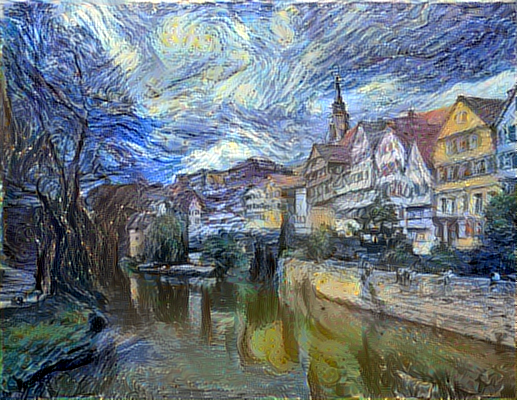

# 9) Cambiar las imágenes de contenido y estilo por unas elegidas por usted. Adjuntar el resultado.

Respuesta:

Link a las pruebas realizadas con otras imagenes contenido y estilo.

https://github.com/Quiroo/Trabajo-Final-CV/tree/main/9_test_otros
